In [1]:
#    GNU LESSER GENERAL PUBLIC LICENSE
#    Version 3, 29 June 2007
#    Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>
#    Everyone is permitted to copy and distribute verbatim copies
#    of this license document, but changing it is not allowed.

#    James Gaboardi, 2016

# Integrating PySAL.Network with Gurobi, CPLEX, & COIN-OR for optimization of the *p*-Center facility location problem
----

## James Gaboardi &nbsp;| &nbsp;Florida State University&nbsp;| &nbsp;Department of Geography 

In [2]:
# Local path on user's machine
path = '/Users/jgaboardi/FacilityLocation/Data/'

## The *p*-Center Problem $\Rightarrow$ "minimum worst case" $\Rightarrow$ equity

The objective of the *p*-center problem, also know as the minimax problem and the PCP, is to 
minimize the worst case cost (*W*) scenario while siting [*p*] facilities to serve all demand/client nodes.  It was originally proposed by Minieka as the *m*-Center problem (1970) and is well-studied in Geography, Operations Research, Mathematics, etc.  In this notebook the network-based vertice PCP is used meaning the cost will be calculated on a topologically accurate road network with `pysal.Network` and solutions will be determined based on discrete locations with `Gurobi`, `CPLEX`, and `COIN-OR`.  Cost is defined as distance here.

*For more information refer to references section.*

**Minimize**

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $W$

**Subject to**

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{j\in m} x_{ij} = 1,$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   $\forall i \in n$

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle\sum_{j \in m} y_j = p$

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{ij} - y_j \geq 0,$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\forall i\in n, j \in m$

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\displaystyle W \geq \sum_{j \in m} c_{ij} x_{ij}$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in n$

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{ij}, y_j \in \{0,1\}$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in n, j \in m$

**where**

- $W$ = the worst case cost between a client and a service node
- $i$ = a specific origin
- $j$ = a specific destination
- $n$ = the set of origins
- $m$ = the set of destinations
- $a_i$ = weight at each node
- $c_{ij}$ = travel costs between nodes
- $x_{ij}$ = the decision variable at each node in the matrix
- $y_j$ = nodes chosen as service facilities
- $p$ = the number of facilities to be sited

-----

Adapted from:
- ***Daskin, M. S. 1995***. Network and Discrete Location: Models, Algorithms, and Applications. Hoboken, NJ, USA: John Wiley & Sons, Inc.

# Imports

In [3]:
import pysal as ps
import geopandas as gpd
import numpy as np
import networkx as nx
import shapefile as shp
from shapely.geometry import Point
import shapely
from collections import OrderedDict
import pandas as pd
import qgrid
import gurobipy as gbp
import cplex as cp
import time
import bokeh
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook, output_file, show
from bokeh.models import (HoverTool, BoxAnnotation, GeoJSONDataSource, 
                          GMapPlot, GMapOptions, ColumnDataSource, Circle, 
                          DataRange1d, PanTool, WheelZoomTool, BoxSelectTool,
                          ResetTool, MultiLine)
import utm
from cylp.cy import CyCbcModel, CyClpSimplex
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize']=8,8
output_notebook()

/Users/jgaboardi/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Loading BokehJS ...

# Data Prep

### Reproject the street network with `GeoPandas` --> Waverly  Hills

In [4]:
STREETS_Orig = gpd.read_file(path+'Waverly_Trim/Waverly.shp')
STREETS = gpd.read_file(path+'Waverly_Trim/Waverly.shp')
STREETS.to_crs(epsg=2779, inplace=True) # NAD83(HARN) / Florida North
STREETS.to_file(path+'WAVERLY/WAVERLY.shp')

### Instantiate the network

In [5]:
# Network
ntw = ps.Network(path+'WAVERLY/WAVERLY.shp')
shp_W = ps.open(path+'WAVERLY/WAVERLY.shp')

### Create 200-meter buffer of the streets then unary union

In [6]:
# Buffer
buff = STREETS.buffer(200)  #Buffer
buffU = buff.unary_union  #Buffer Union
buff1 = gpd.GeoSeries(buffU)
buff1.crs = STREETS.crs
Buff = gpd.GeoDataFrame(buff1, crs=STREETS.crs)
Buff.columns = ['geometry']

### Create random points within the bounds of `WAVERLY.shp`

In [7]:
# Random Points
np.random.seed(352)
x = np.random.uniform(shp_W.bbox[0], shp_W.bbox[2], 1000)
np.random.seed(850)
y = np.random.uniform(shp_W.bbox[1], shp_W.bbox[3], 1000)  
coords0= zip(x,y)
coords = [shapely.geometry.Point(i) for i in coords0]
Rand = gpd.GeoDataFrame(coords)
Rand.crs = STREETS.crs
Rand.columns = ['geometry']

### Keep only the points within the unary union buffer

In [8]:
# Points in Buffer
Inter = [Buff['geometry'].intersection(p) for p in Rand['geometry']]
INTER = gpd.GeoDataFrame(Inter, crs=STREETS.crs)
INTER.columns = ['geometry']

### Simulate clients & service facilities by keeping the 100 and last 15 points, then write each out to a shapefile

In [9]:
# Add records that are points within the buffer
point_in = []
for p in INTER['geometry']:
    if type(p) == shapely.geometry.point.Point:
        point_in.append(p)
# Keep First 100 and last 15 for clients & service
CLIENT = gpd.GeoDataFrame(point_in[:100], crs=STREETS.crs)
CLIENT.columns = ['geometry']
SERVICE = gpd.GeoDataFrame(point_in[-15:], crs=STREETS.crs)
SERVICE.columns = ['geometry']
CLIENT.to_file(path+'CLIENT')
SERVICE.to_file(path+'SERVICE')

### Instanitate non-solution graphs

In [10]:
g = nx.Graph() # Roads & Nodes
g1 = nx.MultiGraph() # Edges and Vertices
GRAPH_client = nx.Graph() # Clients 
g_client = nx.Graph() # Snapped Clients
GRAPH_service = nx.Graph() # Service
g_service = nx.Graph() # Snapped Service

### Instantiate and fill Client and Service point dictionaries

In [11]:
points_client = {} 
points_service = {}

CLI = ps.open(path+'CLIENT/CLIENT.shp')
for idx, coords in enumerate(CLI):
    GRAPH_client.add_node(idx)
    points_client[idx] = coords
    GRAPH_client.node[idx] = coords

SER = ps.open(path+'SERVICE/SERVICE.shp')
for idx, coords in enumerate(SER):
    GRAPH_service.add_node(idx)
    points_service[idx] = coords
    GRAPH_service.node[idx] = coords

### Instantiate Client and Service .shp files

In [12]:
# Instantiate Client and Service .shp files
client = shp.Writer(shp.POINT) # Client Shapefile
# Add Random Points
for i,j in CLI:
    client.point(i,j)
# Add Fields
client.field('client_ID')
#client.field('Weight')
counter = 0
for i in range(len(CLI)):
    counter = counter + 1
    client.record('client_' + str(counter))
client.save(path+'Simulated/RandomPoints_CLIENT') # Save Shapefile 

service = shp.Writer(shp.POINT) #Service Shapefile
# Add Random Points
for i,j in SER:
    service.point(i,j)
# Add Fields
service.field('y_ID')
service.field('x_ID')
counter = 0
for i in range(len(SER)):
    counter = counter + 1
    service.record('y' + str(counter), 'x' + str(counter))
service.save(path+'Simulated/RandomPoints_SERVICE') # Save Shapefile 

### Snap Client and Service to network

In [13]:
Snap_C = ntw.snapobservations(path+'Simulated/RandomPoints_CLIENT.shp', 
                 'Rand_Points_CLIENT', attribute=True)
Snap_S = ntw.snapobservations(path+'Simulated/RandomPoints_SERVICE.shp', 
                 'Rand_Points_SERVICE', attribute=True)

### Create and write out snapped service .shp

In [14]:
# Create Lat & Lon lists of the snapped service locations
y_snapped = []
x_snapped = []
for i,j in ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates.iteritems():
    y_snapped.append(j[0]) 
    x_snapped.append(j[1])

# Create and write out snapped service .shp
service_SNAP = shp.Writer(shp.POINT) # Snapped Service Shapefile
# Add Points
for i,j in ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates.iteritems():
    service_SNAP.point(j[0],j[1])
# Add Fields
service_SNAP.field('y_ID')
service_SNAP.field('x_ID')
service_SNAP.field('LAT')
service_SNAP.field('LON')
counter = 0
for i in range(len(ntw.pointpatterns['Rand_Points_SERVICE'].snapped_coordinates)):
    counter = counter + 1
    service_SNAP.record('y' + str(counter), 'x' + str(counter), y_snapped[i], x_snapped[i])
    service_SNAP.save(path+'Snapped/SERVICE_Snapped') # Save Shapefile 

# What we have thus far:

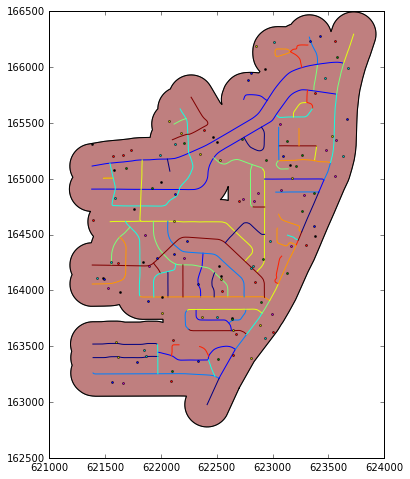

In [15]:
Buff.plot()
STREETS.plot()
CLIENT.plot()
SERVICE.plot(colormap=True)

## Client to Service Distance Matrix

In [16]:
All_Neigh_Dist = ntw.allneighbordistances(    # in meters
                        sourcepattern=ntw.pointpatterns['Rand_Points_CLIENT'],
                        destpattern=ntw.pointpatterns['Rand_Points_SERVICE'])
All_Dist_MILES = All_Neigh_Dist * 0.000621371 # to miles

------------

# Create `.lp` file

In [31]:
# p-Center Facility Location Problem
# This script creates a linear programming file to be read into an optimizer.
'''
GNU LESSER GENERAL PUBLIC LICENSE
                       Version 3, 29 June 2007

 Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>
 Everyone is permitted to copy and distribute verbatim copies
 of this license document, but changing it is not allowed.
'''
# Developed by:  James D. Gaboardi, MSGIS
#                03/2015
#                James Gaboardi

#   Terminology & General Background for Facility Location and Summation Notation:

#   *        The objective of the p-center Facility Location Problem is 
#            to minimize the maximum cost of travel between service 
#            facilities and clients on a network.

#   *   [i] - a specific origin
#   *   [j] - a specifc destination
#   *   [n] - the set of origins
#   *   [m] - the set of destinations
#   *   [Cij] - travel costs between nodes
#   *   [W] - the maximum travel costs between service facilities and clients 
#   *   [x#_#] - the client decision variable
#   *   [y#] - the service decision variable
#   *   [p] - the number of facilities to be sited

#****************************************************************************
'''
|    How many candidate sites [p] can be selected?
'''
p = 5

#****************************************************************************


#    DEFINED FUNCTIONS
# Assignment Constraints
def get_assignment_constraints():
    outtext = ' '
    for i in range(1,rows+1):
        temp = ' '
        for j in range(1,cols+1):
            temp += 'x' + str(i) + '_' + str(j) + ' + '
        outtext += temp[:-2] + '= 1\n'
    return outtext

# Facility Constraint  
def get_p_facilities(p):
    outtext = ''
    for i in range(1, cols+1):
        temp = ''
        temp += 'y' + str(i)
        outtext += temp + ' + '
    outtext = ' ' + outtext[:-2] + '= '+ str(p) + '\n'
    return outtext

# Opening Constraints
def get_opening_constraints_p_center():
    outtext = ''
    for i in range(1, cols+1):
        for j in range(1, rows+1):
            outtext += ' - x' + str(j) + '_' + str(i) + ' + ' + 'y' + str(i) +  ' >= 0\n'
    return outtext

# Maximum Cost Constraints
def get_max_cost():
    outtext = ''
    for i in range(rows):
        temp = '  '
        for j in range(cols):
            temp += str(Cij[i,j]) + ' x' + str(i+1) + '_' + str(j+1) + ' + '
        outtext += temp[:-2] + '- W <= 0\n'
    return outtext

# Declaration of Bounds
def get_bounds_allocation():
    outtext = ' '
    for i in range(rows):
        temp = ''
        for j in range(cols):
            temp += ' 0 <= x' + str(i+1) + '_' + str(j+1) + ' <= 1\n'
        outtext += temp    
    return outtext

def get_bounds_facility():
    outtext = ''
    for i in range(cols):
        outtext += ' 0 <= y' + str(i+1) + ' <= 1\n'
    return outtext

# Declaration of Decision Variables (form can be: Binary, Integer, etc.)
def get_decision_variables_p_center():
    outtext = ' '
    for i in range(1, rows+1):
        temp = ''
        for j in range(1, cols+1):
            temp += 'x' + str(i) + '_' + str(j) + '\n'
        outtext += temp
    return outtext
    
def get_facility_decision_variables_p_center():  
    outtext = ''
    for i in range (1, cols+1):
        outtext += 'y' + str(i) + ' '
    return outtext    

#    DATA READS & VARIABLE DECLARATION
Cij = All_Dist_MILES
rows,cols = Cij.shape

#    START TEXT FOR .lp FILE
# Declaration of Objective Function
text = 'Minimize\n'
text += ' obj: W\n'
# Declaration of Constraints
text += 'Subject To\n'                    
text += get_assignment_constraints()
text += get_p_facilities(p)
text += get_opening_constraints_p_center()
text += get_max_cost()
# Declaration of Bounds
text += 'Bounds\n'
text += get_bounds_allocation()
text += get_bounds_facility()
# Declaration of Decision Variables form: Binaries
text += 'Binaries\n'
text += get_decision_variables_p_center()
text += get_facility_decision_variables_p_center()
text += '\n'
text += 'End\n'
text += "'''\n"
text += "James Gaboardi, 2015"
                
#   CREATE & WRITE .lp FILE TO DISK
# Fill path name  --  File name must not have spaces.
outfile = open(path+'LP_Files/pCenter_Manual.lp', 'w')
outfile.write(text)
outfile.close()

-------------

# Solutions

## Gurobi

In [32]:
t1 = time.time()

gbp.setParam('MIPFocus', 2)                 # Set MIP focus to 'Optimal' --> 2
# Instantiate Optimization model from .lp file
Gurobi_PCP = gbp.read(path+'LP_Files/pCenter_Manual.lp')   

Gurobi_PCP.optimize()
t2 = time.time()-t1

# Record and Display Results
print '\n*************************************************************************'
selected_Gurobi_PCP = []
dbf1 = ps.open(path+'Snapped/SERVICE_Snapped.dbf')
NEW_Records_PCP_Gurobi = []
for v in Gurobi_PCP.getVars():
    if 'x' in v.VarName:
        pass
    elif 'W' in v.VarName:
        pass
    elif v.x > 0:
        var = '%s' % v.VarName
        selected_Gurobi_PCP.append(var)
        for i in range(dbf1.n_records):
            if var in dbf1.read_record(i):
                x = dbf1.read_record(i)
                NEW_Records_PCP_Gurobi.append(x)
            else:
                pass
        print '    |                                            ', var
print '    | Selected Facility Locations -------------- ^^^^ '
print '    | Candidate Facilities [p] ----------------- ', len(selected_Gurobi_PCP)
print '    | Objective Value (miles) ------------------ ', Gurobi_PCP.objVal
print '    | Real Time to Optimize (sec.) ------------- ', t2
print '*************************************************************************'
print ' -- The p-Center Problem Gurobi -- '

Parameter MIPFocus unchanged
   Value: 2  Min: 0  Max: 3  Default: 0
Optimize a model with 1701 rows, 1516 columns and 6115 nonzeros
Coefficient statistics:
  Matrix range    [2e-03, 3e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 5e+00]
Presolve time: 0.03s
Presolved: 1701 rows, 1516 columns, 6015 nonzeros
Variable types: 1 continuous, 1515 integer (1515 binary)
Found heuristic solution: objective 2.1103205
Found heuristic solution: objective 2.0703495
Found heuristic solution: objective 2.0155480
Presolve removed 112 rows and 112 columns
Presolved: 1589 rows, 1404 columns, 5567 nonzeros


Root relaxation: objective 7.212557e-01, 955 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.72126    0  263    2.01555    0.72126  64.2%     -    0s
H    0     0                       2.0143382    0.7212

## CPLEX

In [33]:
t1 = time.time()

# Instantiate Optimization model from .lp file
CPLEX_PCP = cp.Cplex(path+'LP_Files/pCenter_Manual.lp')   

# Set MIP Emphasis to '2' --> Optimal
CPLEX_PCP.parameters.emphasis.mip.set(2)

CPLEX_PCP.solve()
t2 = time.time()-t1

cplex_vars = []
counter = -1
for f in CPLEX_PCP.solution.get_values():
    counter = counter+1
    if 'y' in CPLEX_PCP.variables.get_names()[counter]:
        if f == 1:
            cplex_vars.append(CPLEX_PCP.variables.get_names()[counter])
print '*************************************************************************'
print '    | Selected Facility Locations -------------- ', cplex_vars
print '    | Candidate Facilities [p] ----------------- ', len(cplex_vars)
print '    | Objective Value (miles) ------------------ ', CPLEX_PCP.solution.get_objective_value()
print '    | Real Time to Optimize (sec.) ------------- ', t2
print '*************************************************************************'
print ' -- The p-Center Problem CPLEX -- '

Tried aggregator 1 time.
MIP Presolve modified 1753 coefficients.
Reduced MIP has 1701 rows, 1516 columns, and 5861 nonzeros.
Reduced MIP has 1515 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (10.80 ticks)
Found incumbent of value 3.041143 after 0.02 sec. (20.47 ticks)
Probing time = 0.00 sec. (2.82 ticks)
Tried aggregator 1 time.
Reduced MIP has 1701 rows, 1516 columns, and 5861 nonzeros.
Reduced MIP has 1515 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.27 ticks)
Probing time = 0.00 sec. (2.83 ticks)
Clique table members: 1600.
MIP emphasis: optimality.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.02 sec. (28.12 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            3.0411        0.6923      683   77.23%
*     0+    0

## COIN-OR (CyLP with CLP and CBC)

In [34]:
t1 = time.time()

Cy_PCP = CyClpSimplex()

Cy_PCP.readLp(path+'LP_Files/pCenter_Manual.lp')

Cy_PCP.primal()
Cy_PCP.dual()
CyBB_PCP = Cy_PCP.getCbcModel()
CyBB_PCP.branchAndBound()
CyBB_PCP.bestPossibleObjValue

selected_COIN_PCP = []
for i in CyBB_PCP.primalVariableSolution.sol.keys():
    if 'y' in i:
        selected_COIN_PCP.append(i)

t2 = time.time()-t1
        
print '*************************************************************************'
print '    | Selected Facility Locations -------------- ', selected_COIN_PCP
print '    | Candidate Facilities [p] ----------------- ', len(selected_COIN_PCP), '           '
print '    | Objective Value (miles) ------------------ ', CyBB_PCP.bestPossibleObjValue
print '    | Real Time to Optimize (sec.) ------------- ', t2
print '*************************************************************************'
print ' -- The p-Center Problem COIN-OR -- '

*************************************************************************
    | Selected Facility Locations --------------  ['y9', 'y4', 'y7', 'y6', 'y14']
    | Candidate Facilities [p] -----------------  5            
    | Objective Value (miles) ------------------  0.921797580817
    | Real Time to Optimize (sec.) -------------  30.2529609203
*************************************************************************
 -- The p-Center Problem COIN-OR -- 


---

### Objective Values to 15 significant digits

In [35]:
print 'Equal Objective Values? ', (round(Gurobi_PCP.objVal,15) == 
                                   round(CPLEX_PCP.solution.get_objective_value(),15) == 
                                   round(CyBB_PCP.bestPossibleObjValue,15))

Equal Objective Values?  True


### Objective Values to 16 significant digits

In [36]:
print 'Equal Objective Values? ', (round(Gurobi_PCP.objVal, 16) == 
                                   round(CPLEX_PCP.solution.get_objective_value(),16) == 
                                   round(CyBB_PCP.bestPossibleObjValue, 16))

Identical Facility Selection?  True


### Site Selection

In [46]:
print 'Identical Facility Selection? ', (selected_Gurobi_PCP == 
                                           cplex_vars == 
                                           selected_COIN_PCP)

print 'Gurobi : ', selected_Gurobi_PCP
print 'CPLEX  : ', cplex_vars
print 'COIN-OR: ', selected_COIN_PCP

Identical Facility Selection?  False
Gurobi :  ['y4', 'y6', 'y7', 'y9', 'y14']
CPLEX  :  ['y4', 'y6', 'y7', 'y9', 'y15']
COIN-OR:  ['y9', 'y4', 'y7', 'y6', 'y14']


## Pandas dataframe

In [49]:
p_center = pd.DataFrame(columns=
                        ['Obj. Value (15 sig.)', 'Obj. Value (16 sig.)'], 
                        index=['Gurobi', 'CPLEX', 'COIN-OR'])
pd.set_option('precision', 20)

objective_values_15 = [round(Gurobi_PCP.objVal,15), 
                        round(CPLEX_PCP.solution.get_objective_value(),15),
                        round(CyBB_PCP.bestPossibleObjValue,15)]
objective_values_16 = [round(Gurobi_PCP.objVal,16), 
                        round(CPLEX_PCP.solution.get_objective_value(),16),
                        round(CyBB_PCP.bestPossibleObjValue,16)]

p_center['Obj. Value (15 sig.)'] = objective_values_15
p_center['Obj. Value (16 sig.)'] = objective_values_16
p_center['Site Selection'] = selected_Gurobi_PCP, cplex_vars, selected_COIN_PCP
p_center.index.name = ' Optimizer ' 
p_center

,Obj. Value (15 sig.),Obj. Value (16 sig.),Site Selection
Optimizer,,,
Gurobi,0.92179758081700002847,0.92179758081700002847,"[y4, y6, y7, y9, y14]"
CPLEX,0.92179758081700002847,0.92179758081700002847,"[y4, y6, y7, y9, y15]"
COIN-OR,0.92179758081700002847,0.92179758081700002847,"[y9, y4, y7, y6, y14]"


- ** The results are highly variable between these optimization suites, most likely due to different default settings and algorithms employeed.**

- ** With various [p] the same facilities can be chosen with differing objective values and vice versa.**

## Coordinate conversion for Google Map overlay 

In [40]:
p_list = []
for i in range(1, len(SER)+1):
    p = 'p'+str(i)
    p_list.append(p)

y_list = []
for i in range(1, len(SER)+1):
    y = 'y'+str(i)
    y_list.append(y)

points = SERVICE
points.to_crs(epsg=32616, inplace=True) # UTM 16N
LonLat_Dict = OrderedDict()
LonLat_List = []

for i,j in points['geometry'].iteritems():
    LonLat_Dict[y_list[i]] = utm.to_latlon(j.xy[0][-1], j.xy[1][-1], 16, 'N')  
    LonLat_List.append((utm.to_latlon(j.xy[0][-1], j.xy[1][-1], 16, 'N')))

Service_Lat_List = []
Service_Lon_List = []
    
for i in LonLat_List:
    Service_Lat_List.append(i[0])
for i in LonLat_List:
    Service_Lon_List.append(i[1])

## Google Map overlay

In [52]:
Gurobi_sites = []
for y in y_list:
    if y in selected_Gurobi_PCP:
        Gurobi_sites.append(' Selected ')
    else:
        Gurobi_sites.append(' -- ')
CPLEX_sites = []
for y in y_list:
    if y in cplex_vars:
        CPLEX_sites.append(' Selected ')
    else:
        CPLEX_sites.append(' -- ')
COIN_sites = []
for y in y_list:
    if y in selected_COIN_PCP:
        COIN_sites.append(' Selected ')
    else:
        COIN_sites.append(' -- ')

map_options = GMapOptions(lat=30.4855, lng=-84.265, map_type="hybrid", zoom=14)

plot = GMapPlot(
    x_range=DataRange1d(), 
    y_range=DataRange1d(), 
    map_options=map_options, title="Waverly Hills")

hover = HoverTool(tooltips="""
        <div>
            <div>
                
            </div>
            <div>
                <span style="font-size: 30px; font-weight: bold;">PCP Site @desc</span> 
            </div>
            <div>
                <span> \b </span>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">Gurobi: </span> 
            </div>
                <div>
                <span style="font-size: 15px; font-weight: bold; color: #ff4d4d;">@select_center_Gurobi</span>
            </div>
            <div>
                <span> \b </span>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">CPLEX</span> 
            
            <div>
                <span style="font-size: 14px; font-weight: bold; color: #00b300;">@select_center_CPLEX</span>
            </div>
            <div>
                <span> \b </span>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">COIN-OR</span> 
            </div>
            <div>
                <span style="font-size: 14px; font-weight: bold; color: #3385ff;">@select_center_COIN</span>
            </div>
        </div>""")

source_1 = ColumnDataSource(
        data=dict(
        lat=Service_Lat_List,
        lon=Service_Lon_List,
        desc=y_list,
        select_center_Gurobi=Gurobi_sites,
        select_center_CPLEX=CPLEX_sites,
        select_center_COIN=COIN_sites))

facilties = Circle(x="lon", y="lat", 
                   size=10, fill_color="yellow", 
                   fill_alpha=0.6, line_color=None)

plot.add_glyph(source_1, facilties)

plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool(), ResetTool(), hover)
output_file("gmap_plot.html")
show(plot)

['y4', 'y6', 'y7', 'y9', 'y14']
['y4', 'y6', 'y7', 'y9', 'y15']
['y9', 'y4', 'y7', 'y6', 'y14']


---

### System Specs

In [53]:
import datetime as dt
import os
import platform
import sys
import bokeh
import cylp

names = ['OSX', 'Processor ', 'Machine ', 'Python ','PySAL ','Gurobi ','Pandas ','GeoPandas ',
         'Shapely ', 'NumPy ', 'Bokeh ', 'CyLP', 'Date & Time']
versions = [platform.mac_ver()[0], platform.processor(), platform.machine(), platform.python_version(),
            ps.version, gbp.gurobi.version(), pd.__version__, gpd.__version__, 
            str(shapely.__version__), np.__version__, 
            bokeh.__version__, '0.7.1', dt.datetime.now()]
specs = pd.DataFrame(index=names, columns=['Version'])
specs.columns.name = 'Platform & Software Specs'
specs['Version'] = versions
specs # Pandas DF of specifications

Platform & Software Specs,Version
OSX,10.11.3
Processor,i386
Machine,x86_64
Python,2.7.10
PySAL,1.11.0
Gurobi,"(6, 5, 0)"
Pandas,0.17.1
GeoPandas,0.1.1
Shapely,1.5.13
NumPy,1.9.2


---

### email $\Longrightarrow$ jgaboardi@fsu.edu 
### GitHub $\Longrightarrow$ https://github.com/jGaboardi
### LinkedIn $\Longrightarrow$ https://www.linkedin.com/in/jamesgaboardi
### Florida State University $\Longrightarrow$ http://geography.fsu.edu/people/james-gaboardi/

---

### References

- Behnel, S., R. Bradshaw, C. Citro, L. Dalcin, D. S. Seljebotn, and K. Smith. 2011. Cython: The best of both worlds. Computing in Science and Engineering 13 (2):31–39.

- Bokeh Development Team. 2014. Bokeh: Python library for interactive visualization.

- Church, R. L. 2002. Geographical information systems and location science. Computers and Operations Research 29:541–562.

- Church, R. L., and A. T. Murray. 2009. Business Site Selections, Locational Analysis, and GIS. Hoboken, NJ, USA: John Wiley & Sons, Inc.

- Conde, E. 2008. A note on the minmax regret centdian location on trees. Operations Research Letters 36 (2):271–275.

- Current, J., M. S. Daskin, and D. A. Schilling. 2002. Discrete Network Location Models. In Facility Location Applications and Theory, eds. Z. Drezner and H. W. Hamacher, 81–118. New York: Springer Berlin Heidelberg.

- Dan Fylstra, L. Hafer, B. Hart, B. Kristjannson, C. Phillips, T. Ralphs, (Matthew Saltzman, E. Straver, (Jean-Paul Watson, and H. G. Santos. CBC. https://projects.coin-or.org/Cbc.

- Daskin, M. 2013. Network and Discrete Location: Models, Algorithms and Applications 2nd ed. Hoboken, NJ, USA: John Wiley & Sons, Inc.

- Daskin, M. S. 2008. What You Should Know About Location Modeling. Naval Research Logistics 55 (2):283–294.

- GeoPandas Developers. 2013. GeoPandas. http://geopandas.org.

- Gillies, S., A. Bierbaum, and K. Lautaportti. 2013. Shapely.

- Gurobi. 2013. Gurobi optimizer quick start guide.

- Hagberg, A. A., D. A. Schult, and P. J. Swart. 2008. Exploring network structure, dynamics, and function using NetworkX. Proceedings of the 7th Python in Science Conference (SciPy 2008) (SciPy):11–15.

- Hakimi, S. L. 1964. Optimum Locations of Switching Centers and the Absolute Centers and Medians of a Graph. Operations Research 12 (3):450–459.

- Hall, J., L. Hafer, M. Saltzman, and J. Forrest. CLP.

- Halpern, J. 1976. The Location of a Center-Median Convex Combination on an Undirected Tree. Journal of Regional Science 16 (2):237–245.

- Hamacher, H. W., and S. Nickel. 1998. Classification of location models. Location Science 6 (1-4):229–242.

- Horner, M. W., and M. J. Widener. 2010. How do socioeconomic characteristics interact with equity and efficiency considerations? An analysis of hurricane disaster relief goods provision. Geospatial Analysis and Modelling of Urban Structure and Dynamics 99:393–414.

- Horner, M. W., and M. J. Widener. 2011. The effects of transportation network failure on people’s accessibility to hurricane disaster relief goods: A modeling approach and application to a Florida case study. Natural Hazards 59:1619–1634.

- Hunter, J. D. 2007. Matplotlib: A 2D graphics environment. Computing in Science and Engineering 9 (3):99–104.

- Lima, I. 2006. Python for Scientific Computing Python Overview. Marine Chemistry :10–20.

- Lougee-Heimer, R. 2003. The Common Optimization INterface for Operations Research. IBM Journal of Research and Development 47 (1):57–66.

- Marcelin, J. M., M. W. Horner, E. E. Ozguven, and A. Kocatepe. 2016. How does accessibility to post-disaster relief compare between the aging and the general population? A spatial network optimization analysis of hurricane relief facility locations. International Journal of Disaster Risk Reduction 15:61–72.

- McKinney, W. 2010. Data Structures for Statistical Computing in Python. In Proceedings of the 9th Python in Science Conference, 51–56.

- Miller, H. J., and S.-L. Shaw. 2001. Geographic Information Systems for Transportation. New York: Oxford University Press.

- Millman, K. J., and M. Aivazis. 2011. Python for scientists and engineers. Computing in Science and Engineering 13 (2):9–12.

- Minieka, E. 1970. The m-Center Problem. SIAM Review 12:38–39.

- Owen, S. H., and M. S. Daskin. 1998. Strategic facility location: A review. European Journal of Operational Research 111 (3):423–447.

- Pérez, F., and B. E. Granger. 2007. IPython: A system for interactive scientific computing. Computing in Science and Engineering 9 (3):21–29.

- Pérez-Brito, D., J. A. Moreno-Pérez, and R.-M. Inmaculada. 1997. Finite dominating set for the p-facility cent-dian network location problem. Studies in Locational Analysis (August):1–16.

- Pérez-Brito, D., J. A. Moreno-Pérez, and I. Rodrı́guez-Martı́n. 1998. The 2-facility centdian network problem. Location Science 6 (1-4):369–381.

- QGIS Development Team. Open Source Geospatial Foundation Project. 2016. QGIS Geographic Information System.

- ReVelle, C. S., and R. W. Swain. 1970. Central facilities location. Geographical Analysis 2 (1):30–42.

- Rey, S. J., and L. Anselin. 2010. PySAL: A Python Library of Spatial Analytical Methods. In Handbook of Applied Spatial Analysis, eds. M. M. Fischer and A. Getis, 175–193. Springer Berlin Heidelberg.

- Shier, D. R. 1977. A Min–Max Theorem for p-Center Problems on a Tree. Transportation Science 11:243–52.

- Suzuki, A., and Z. Drezner. 1996. The p-center location problem in an area. Location Science 4 (1-2):69–82.

- Tamir, A., J. Puerto, and D. Pérez-Brito. 2002. The centdian subtree on tree networks. Discrete Applied Mathematics 118 (3):263–278.

- Teitz, M. B., and P. Bart. 1968. Heuristic Methods for Estimating the Generalized Vertex Median of a Weighted Graph. Operations Research 16 (5):955–961.

- Tong, D., and A. T. Murray. 2012. Spatial Optimization in Geography. Annals of the Association of American Geographers 102 (6):1290–1309.

- Towhidi, M., and D. Orban. 2011. CyLP.

- US Census Bureau. 2015. TIGER/Line® Shapefiles and TIGER/Line® Files. U.S. Census Bureau Geography. https://www.census.gov/geo/maps-data/data/tiger-line.html.

- Walt, S. van der, S. C. Colbert, and G. Varoquaux. 2011. The NumPy Array: A Struture for Efficient Numerical Computation. Computing in Science & Engeneering 13:22–30.

- William, R. 1971. The M-center problem.

-------------